_Lambda School Data Science — Tree Ensembles_ 

# Decision Trees

### Pre-read / pre-watch
- A Visual Introduction to Machine Learning, [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/),  and [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [How a Russian mathematician constructed a decision tree - by hand - to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)


### Categorical encoding for trees

#### Good reads
- [Categorical Features and Encoding in Decision Trees](https://medium.com/data-design/visiting-categorical-features-and-encoding-in-decision-trees-53400fa65931)
- [Beyond One-Hot: An Exploration of Categorical Variables](http://www.willmcginnis.com/2015/11/29/beyond-one-hot-an-exploration-of-categorical-variables/)
- [Mean (likelihood) encodings: a comprehensive study](https://www.kaggle.com/vprokopev/mean-likelihood-encodings-a-comprehensive-study)
- [Are categorical variables getting lost in your random forests?](https://roamanalytics.com/2016/10/28/are-categorical-variables-getting-lost-in-your-random-forests/)

#### Some options
- [category_encoders.target_encoder.OrdinalEncoder](http://contrib.scikit-learn.org/categorical-encoding/ordinal.html)
- [category_encoders.target_encoder.TargetEncoder](http://contrib.scikit-learn.org/categorical-encoding/targetencoder.html)
- [sklearn.preprocessing.LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) + [sklearn.compose.ColumnTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html#sklearn.compose.ColumnTransformer)
- [sklearn.preprocessing.LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) + [sklearn-pandas](https://github.com/scikit-learn-contrib/sklearn-pandas)
- [kaggler.preprocessing.data.OneHotEncoder(min_obs=...)](https://pythonhosted.org/Kaggler/kaggler.preprocessing.html#kaggler.preprocessing.data.OneHotEncoder)
- [Create your own scikit-learn compatible transformers!](https://github.com/PacktPublishing/Hands-On-Machine-Learning-with-Python-and-Scikit-Learn/blob/master/code/Feature%20Engineering.ipynb)

### Libraries

This notebook optionally uses the [dtreeviz](https://explained.ai/decision-tree-viz/) library for decision tree visualizations.

It is easy to install on Google Colab: `!pip install dtreeviz`

But the [installation instructions](https://github.com/parrt/dtreeviz#install) are harder on Mac or Windows. 

So you have several options with this notebook:
1. Run on Google Colab
2. Install dtreeviz on your system
3. Skip the cells with dtreeviz

In [ ]:
#pip install dtreeviz

This notebook also uses the [category_encoders](https://github.com/scikit-learn-contrib/categorical-encoding) library.

To install on Google Colab: `!pip install category_encoders`

To install with Anaconda: `!conda install -c conda-forge category_encoders`


In [ ]:
#pip install category_encoders

## Play Tennis

We'll reproduce the "Play Tennis" example from Ross Quinlan's 1986 paper, [Induction of Decison Trees](https://link.springer.com/content/pdf/10.1007%2FBF00116251.pdf).

[According to Wikipedia](https://en.wikipedia.org/wiki/Ross_Quinlan), "John Ross Quinlan is a computer science researcher in data mining and decision theory. He has contributed extensively to the development of decision tree algorithms, including inventing the canonical C4.5 and ID3 algorithms."

***"Table 1 shows a small training set"***

In [5]:
import pandas as pd

columns = 'No. Outlook Temperature Humidity Windy Class'.split()

raw = """1 sunny hot high false N
2 sunny hot high true N
3 overcast hot high false P
4 rain mild high false P
5 rain cool normal false P
6 rain cool normal true N
7 overcast cool normal true P
8 sunny mild high false N
9 sunny cool normal false P
10 rain mild normal false P
11 sunny mild normal true P
12 overcast mild high true P
13 overcast hot normal false P
14 rain mild high true N"""

data = [row.split() for row in raw.split('\n')]

tennis = pd.DataFrame(data, columns=columns).set_index('No.')

tennis

,Outlook,Temperature,Humidity,Windy,Class
No.,,,,,
1,sunny,hot,high,false,N
2,sunny,hot,high,true,N
3,overcast,hot,high,false,P
4,rain,mild,high,false,P
5,rain,cool,normal,false,P
6,rain,cool,normal,true,N
7,overcast,cool,normal,true,P
8,sunny,mild,high,false,N
9,sunny,cool,normal,false,P


***"A decision tree that correctly classifies each object in the training set is given in Figure 2."***

<img src="https://i.imgur.com/RD7d0u0.png" height="300">

### Explore the data
(and compare to Figure 2 above)

In this dataset, the tennis player decided to play on 9 days, and decided not to on 5 days.

In [6]:
tennis['Class'] = (tennis['Class'] == 'P').astype(int)
tennis['Class'].value_counts()

1    9
0    5
Name: Class, dtype: int64

The tennis player played on 4 overcast days, 3 rainy days, and 2 sunny days.

In [7]:
tennis.groupby('Outlook')['Class'].sum()

Outlook
overcast    4
rain        3
sunny       2
Name: Class, dtype: int64

On sunny days, the tennis player's decision depends on the humidity. (The Outlook and Humidity features interact.)

In [8]:
tennis[tennis['Outlook']=='sunny'].groupby('Humidity')['Class'].sum()

Humidity
high      0
normal    2
Name: Class, dtype: int64

On rainy days, the tennis player's decision depends on the wind. (The Outlook and Windy features interact.)

In [9]:
tennis[tennis['Outlook']=='rain'].groupby('Windy')['Class'].sum()

Windy
false    3
true     0
Name: Class, dtype: int64

### Train a Decision Tree
The tree has 100% accuracy

In [10]:
from sklearn.tree import DecisionTreeClassifier

X = pd.get_dummies(tennis.drop(columns='Class'))
y = tennis['Class']

dt = DecisionTreeClassifier()
dt.fit(X, y)
dt.score(X, y)

1.0

### Visualize the tree
With dtreeviz:

/home/xailus/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


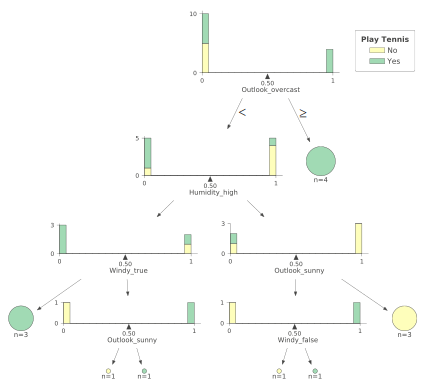

In [11]:
from dtreeviz.trees import dtreeviz

dtreeviz(dt, X, y, 
         target_name='Play Tennis',
         feature_names=X.columns, 
         class_names=['No', 'Yes'])

With scikit-learn:

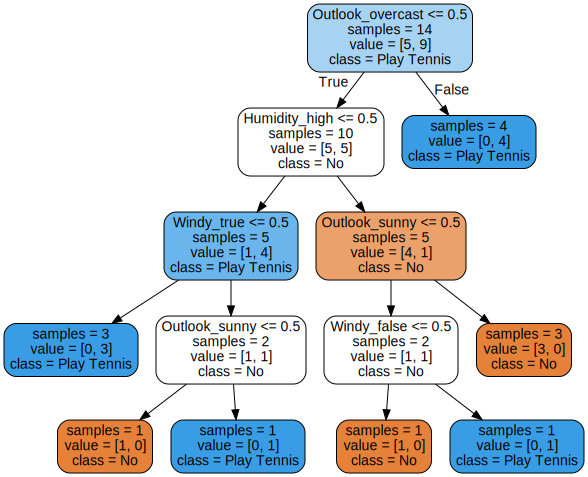

In [12]:
import graphviz
from sklearn.tree import export_graphviz

dot_data = export_graphviz(dt, out_file=None, 
                           feature_names=X.columns, 
                           class_names=['No', 'Play Tennis'],   
                           filled=True, impurity=False, rounded=True)
graphviz.Source(dot_data)

### Compare to Logistic Regression
Logistic Regression has lower accuracy here:

In [13]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='lbfgs')
lr.fit(X, y)
lr.score(X, y)

0.8571428571428571

The Logistic Regression model has these coefficients:

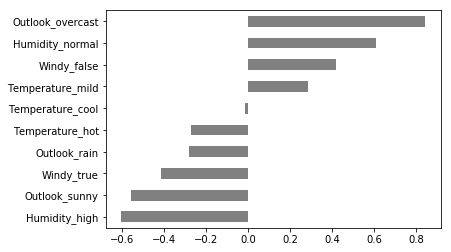

In [14]:
pd.Series(lr.coef_[0], X.columns).sort_values().plot.barh(color='grey');

### What if we use "Ordinal" encoding instead of One-Hot?

The "ordinal" encoding is applied arbitrarily here.

The decision tree still has 100% accuracy.

In [15]:
import category_encoders as ce

encoder = ce.OrdinalEncoder()
X = encoder.fit_transform(tennis.drop(columns='Class'))
y = tennis['Class']

dt = DecisionTreeClassifier()
dt.fit(X, y)
dt.score(X, y)

1.0

A tree's [feature importances](https://explained.ai/rf-importance/index.html#3) are non-negative. They have magnitude but no direction. 

"Outlook" is the most important feature in this model.

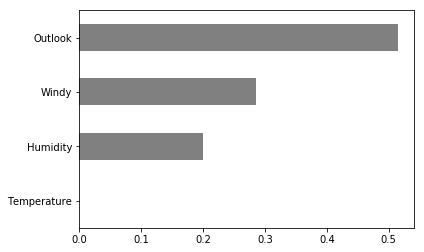

In [16]:
pd.Series(dt.feature_importances_, X.columns).sort_values().plot.barh(color='grey');

With the arbitrary "ordinal" encoding, the Logistic Regression accuracy decreases to 64% (compared to 86% with One-Hot Encoding).

In [17]:
lr = LogisticRegression(solver='lbfgs')
lr.fit(X, y)
lr.score(X, y)

0.6428571428571429

Why? Because now the relatioship between some features and target are not monotonic. 

We can look this, one feature at a time.

In [18]:
Xy = pd.concat([X, y], axis='columns')
Xy.groupby('Outlook')['Class'].sum()

Outlook
1    2
2    4
3    3
Name: Class, dtype: int64

In [19]:
Xy.groupby('Temperature')['Class'].sum()

Temperature
1    2
2    4
3    3
Name: Class, dtype: int64

In [20]:
Xy.groupby('Humidity')['Class'].sum()

Humidity
1    3
2    6
Name: Class, dtype: int64

In [21]:
Xy.groupby('Windy')['Class'].sum()

Windy
1    6
2    3
Name: Class, dtype: int64

The "Humidity" and "Windy" features have monotnic relationships with the target. The other two features do not. This is shown in the model's coefficients.

We know that the "Outlook" feature is important in this dataset, but Logistic Regression cannot model it with an arbitrary "ordinal" encoding.

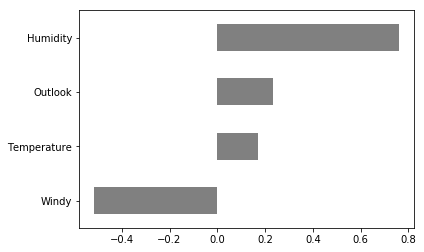

In [22]:
pd.Series(lr.coef_[0], X.columns).sort_values().plot.barh(color='grey');

See the links at the top of this notebook to learn more about categorical encoding for trees.

## Shallow trees are good for fast, first baselines, and to look for "leakage"

[Xavier Amatriain recommends,](https://www.quora.com/What-are-some-best-practices-for-training-machine-learning-models/answer/Xavier-Amatriain)

"Make sure your training features do not contain data from the “future” (aka time traveling). While this might be easy and obvious in some cases, it can get tricky. ... If your test metric becomes really good all of the sudden, ask yourself what you might be doing wrong. Chances are you are time travelling or overfitting in some way."

We can test this with the [UCI repository's Bank Marketing dataset](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing). It has a feature which leaks information from the future and should be dropped:

"11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input ... should be discarded if the intention is to have a realistic predictive model."

So let's download the data ...

In [23]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
%cd bank-additional

--2019-03-19 16:24:46--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.249
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.249|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 444572 (434K) [application/zip]
Saving to: ‘bank-additional.zip’

bank-additional.zip 100%[===================>] 434.15K   462KB/s    in 0.9s    

2019-03-19 16:24:48 (462 KB/s) - ‘bank-additional.zip’ saved [444572/444572]

Archive:  bank-additional.zip
   creating: bank-additional/
  inflating: bank-additional/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/bank-additional/
  inflating: __MACOSX/bank-additional/._.DS_Store  
  inflating: bank-additional/.Rhistory  
  inflating: bank-additional/bank-additional-full.csv  
  inflating: bank-additional/bank-additional-names.txt  
  inflating: bank-additional/bank-additional.csv  
  inflating: __MACOSX/._bank-ad

... and train a shallow tree baseline, without dropping the `duration` feature.

In [24]:
import category_encoders as ce
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

df = pd.read_csv('bank-additional-full.csv', sep=';')
X = df.drop(columns='y')
y = df['y'] == 'yes'

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

pipe = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    DecisionTreeClassifier(max_depth=2)
)

cross_val_score(pipe, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)

array([0.85309963, 0.86704028, 0.85589586, 0.85229795, 0.86402673])

This baseline has a ROC AUC score above 0.85, and it uses the `duration` feature, as well as `nr.employed`, a "social and economic context attribute" for "number of employees - quarterly indicator."

In [25]:
pipe.fit(X_train, y_train)
tree = pipe.named_steps['decisiontreeclassifier']
encoder = pipe.named_steps['onehotencoder']
feature_names = encoder.transform(X_train).columns
feature_names[tree.feature_importances_ > 0]

Index(['duration', 'nr.employed'], dtype='object')

We can visualize the tree:

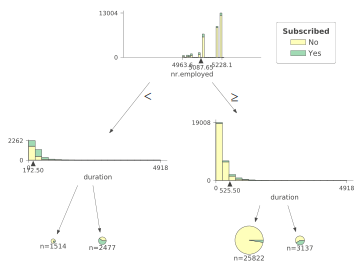

In [26]:
from dtreeviz.trees import dtreeviz

class_names = ['No', 'Yes']
dtreeviz(tree, encoder.transform(X_train), y_train, 
         target_name='Subscribed',
         feature_names=list(feature_names), 
         class_names=class_names)

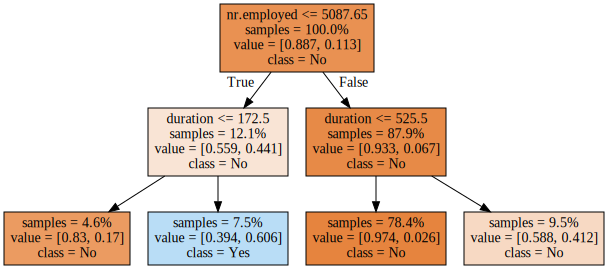

In [27]:
import graphviz
from sklearn.tree import export_graphviz

dot_data = export_graphviz(tree, out_file=None, 
                           feature_names=feature_names, class_names=class_names, 
                           filled=True, impurity=False, proportion=True)

graphviz.Source(dot_data)

### When the `duration` feature is dropped, 
then the ROC AUC score drops from ~0.85 to ~0.75

In [28]:
X_train = X_train.drop(columns='duration')
cross_val_score(pipe, X_train, y_train, cv=5, scoring='roc_auc')

array([0.75192356, 0.73669375, 0.7473569 , 0.73692904, 0.74700667])

### ROC AUC

[Wikipedia explains,](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) "A receiver operating characteristic curve, or ROC curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings."

ROC AUC is the area under the ROC curve. [It can be interpreted](https://stats.stackexchange.com/questions/132777/what-does-auc-stand-for-and-what-is-it) as "the expectation that a uniformly drawn random positive is ranked before a uniformly drawn random negative." 

ROC AUC measures how well a classifier ranks predicted probabilities. It ranges from 0 to 1. A naive majority class baseline will have an ROC AUC score of 0.5. 

Area under the Receiver Operating Characteristic curve: 0.7404622305997627


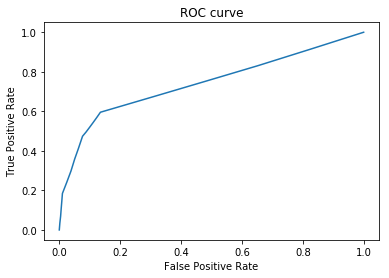

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_predict

y_pred_proba = cross_val_predict(pipe, X_train, y_train, cv=5, n_jobs=-1, 
                                 method='predict_proba')[:, 1]

fpr, tpr, thresholds = roc_curve(y_train, y_pred_proba)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print('Area under the Receiver Operating Characteristic curve:', 
      roc_auc_score(y_train, y_pred_proba))

In [30]:
pd.DataFrame({'False Positive Rate': fpr, 
              'True Positive Rate': tpr, 
              'Threshold': thresholds})

,False Positive Rate,True Positive Rate,Threshold
0,0.000000,0.000000,1.714088
1,0.001847,0.034752,0.714088
2,0.004344,0.068966,0.709202
3,0.006225,0.107220,0.693569
4,0.008174,0.143588,0.692588
5,0.010295,0.184537,0.690387
6,0.024454,0.240571,0.361076
7,0.038306,0.297683,0.356931
8,0.050619,0.358836,0.354826
9,0.062624,0.411099,0.353764
